In [13]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from nsta.core import estimate_jac, estimate_stability_using_particle,estimate_stability_using_particle_from_true_jac
plt.rcParams.update({'font.size': 15})

Let's look at the simplest case possible. We'll estimate the stability of a linear, autonomous RNN: $\mathbf{x}_{t+1} = \mathbf{W}\mathbf{x}_{t}$. Here $\mathbf{x} \in \mathbb{R}^n$ and $\mathbf{W} \in \mathbb{R}^{n \times n}$.

In this case the stability of the RNN is purely determined by the eigenvalues of $\mathbf{W}$ (see pg 21 of Boyd lecture notes for a refresher: https://stanford.edu/class/ee363/lectures/lq-lyap.pdf). 

Specifically, the RNN will be stable when the eigenvalues of $\mathbf{W}$ are inside the unit circle of the complex plane.

In [15]:
def linear_vRNN_update(x,W,t,baseline_FR):
    #update for linear RNN
    return W @ x #+  baseline_FR*np.sin(t/10) + 0.01*np.random.normal(0,1,W.shape[0])#+ 0.1*np.sin(t/10)

def linear_vRNN_jac(x, W):    
    #jacobian of linear RNN
    return W
    
def run_random_vRNN_sim(n,g,T,p):
    #run an n dimensional linear RNN for T timesteps, starting from p different initial conditions.

    #n: number of neurons
    
    #g: chaos dial

    #T: length of sim

    #p: number of trials

    W = np.random.normal(0,g/np.sqrt(n),(n,n))  
    baseline_FR = np.random.normal(0,g,n)  
    
    xsAllTrials = []
    JsAllTrials = []

    for trial in range(p):

        x = np.random.normal(0,1,n)        
        xsOneTrial = []
        JsOneTrial = []
        for time in range(T):

            x = linear_vRNN_update(x,W,time,baseline_FR)
            xsOneTrial.append(x)
            JsOneTrial.append(linear_vRNN_jac(x, W))

        xsAllTrials.append(xsOneTrial)
        JsAllTrials.append(JsOneTrial)
    
    xsAllTrials = np.stack(xsAllTrials)
    JsAllTrials = np.stack(JsAllTrials)

    

    return xsAllTrials, JsAllTrials,W
    

def plot_linear_RNN_summary(W,states):
    #plots eigenvalues and example activations

    fig, ax = plt.subplots(1,2,figsize = (15,5))

    evals,evecs = np.linalg.eig(W)
    max_eig_pos = np.argmax(np.abs(evals))
    t_circle = np.linspace(0,2*np.pi,100)


    ax[0].scatter(evals.real,evals.imag,s = 100)
    ax[0].scatter(evals[max_eig_pos].real,evals[max_eig_pos].imag,color = 'r',s = 200,label = 'Largest Eigenvalue (Abs Val)')
    
    ax[0].plot(np.cos(t_circle), np.sin(t_circle), linewidth=2,color = 'k',label = 'Stability Boundry (Inside = Stable)')
    ax[0].legend(loc = 'upper right')
    ax[0].set_title('Eigenvalues of Weight Matrix')
    ax[0].set_xlabel(r'$Re(\lambda_i)$')
    ax[0].set_ylabel(r'$Im(\lambda_i)$')

    ax[1].plot(states[20,:],color = 'k',alpha = 0.2)
    ax[1].set_title('RNN Activations on A Random Trial')
    ax[1].set_xlabel('Timestep')
    ax[1].set_ylabel('Neural Activation')

    max_eig = np.abs(evals[max_eig_pos])

    plt.tight_layout()
    return max_eig


        

Run the simulations and visualize them.

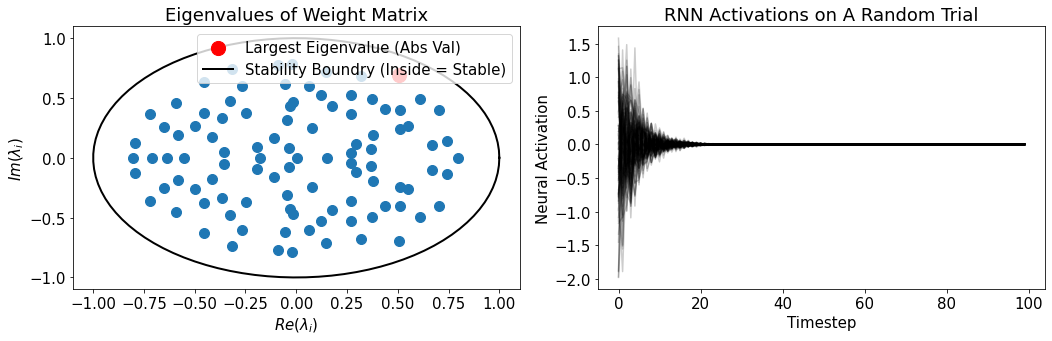

In [31]:
#run linear RNN
states,jacs,W = run_random_vRNN_sim(n = 100,g = 0.85,T =100,p = 1000)
#visualize
max_eig = plot_linear_RNN_summary(W,states)

Estimate Jacobian from data and then estimate largest Lyapunov exponent from estimated Jacobian. 

In [29]:
#estimate jacobian from neural activations
js, cs = estimate_jac(states)
np.random.seed(2)
#estimate largest eigenvalue from estimated jacobian
estimated_lams_with_eigenvectors = estimate_stability_using_particle(js,1000,W,test_eigenvectors=True)
estimated_lams_without_eigenvectors = estimate_stability_using_particle(js,1000,W,test_eigenvectors=False)
estimated_lams_true = estimate_stability_using_particle_from_true_jac(W,p = 1000,T = js.shape[0],test_eigenvectors=True,gen_jac=False)

Text(0.5, 0, '$\\lambda_{max}$')

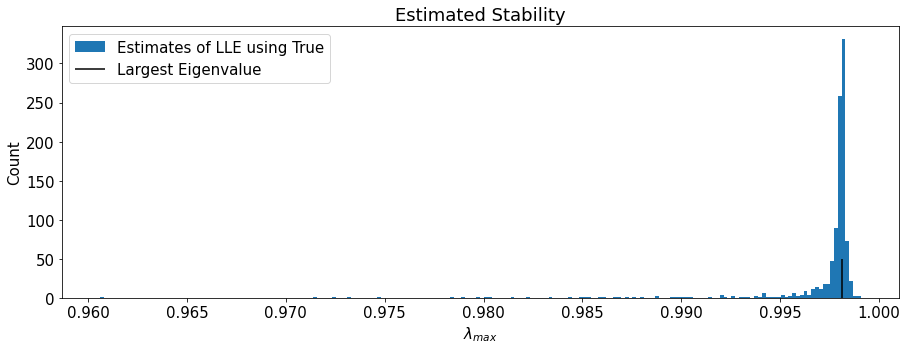

In [30]:

#visualize the estimated stability
fig, ax = plt.subplots(1,1,figsize = (15,5))
#ax.hist(np.exp(estimated_lams_with_eigenvectors),bins = 200,alpha = 0.7,label = 'Estimates of Largest Lyapunov Exponent with EV');
#ax.hist(np.exp(estimated_lams_without_eigenvectors),bins = 200,alpha = 0.7, label = 'Estimates of Largest Lyapunov Exponent without EV');
ax.hist(np.exp(estimated_lams_true),bins = 200,label = 'Estimates of LLE using True')
ax.vlines(max_eig,0,50,'k',label = 'Largest Eigenvalue')
ax.legend()
ax.set_title('Estimated Stability')
ax.set_ylabel('Count')
ax.set_xlabel(r'$\lambda_{max}$')

In [91]:
all_eigs = []
for i in range(js.shape[0]):
    eigs,_ = np.linalg.eig(js[i])
    all_eigs.append(np.max(np.abs(eigs)))
    
#plt.plot(all_eigs)
#plt.plot(np.linalg.norm((js),ord = 'fro', axis = (1,2)))

    #plt.plot(np.linalg.norm((W-js),ord = 'fro', axis = (1,2)))
#np.linalg.norm(,'fro',axis = 2)
#plt.plot(np.linalg.norm(cs,axis = 0))

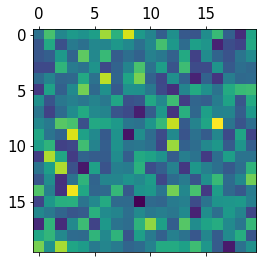

In [92]:
plt.matshow(js[40])

Compare the largest eigenvalue of $\mathbf{W}$ to the estimated largest Lyapunov exponent. It's an exercise for the reader that the estimated largest Lyapunov exponents need to be exponentiated to compare them to the largest eigenvalue of $\mathbf{W}$.

Question for Leo: why do the estimates seem biased to be lower than the largest Lyapunov exponent? 

Text(0.5, 0, '$\\lambda_{max}$')

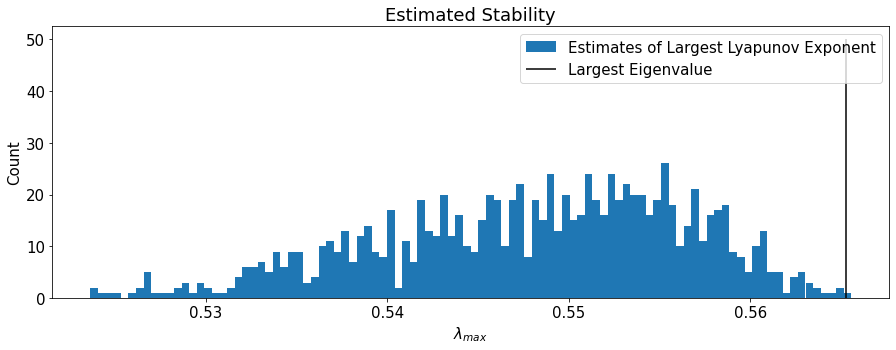

In [121]:
fig, ax = plt.subplots(1,1,figsize = (15,5))
ax.hist(np.exp(estimated_lams),bins = 100,label = 'Estimates of Largest Lyapunov Exponent');
ax.vlines(max_eig,0,50,'k',label = 'Largest Eigenvalue')
ax.legend()
ax.set_title('Estimated Stability')
ax.set_ylabel('Count')
ax.set_xlabel(r'$\lambda_{max}$')

In [113]:

#np.outer(random_scalings,leading_eig_vec)
#leading_eig_vec
#random_scalings_of_lead_eig = np.random.randn(p)

array([[-0.15712812,  0.12703116,  0.07150249, ...,  0.00927992,
         0.06788507,  0.15986709],
       [ 0.216902  , -0.17535571, -0.0987031 , ..., -0.01281014,
        -0.09370956, -0.22068291],
       [ 0.02088406, -0.01688384, -0.00950347, ..., -0.0012334 ,
        -0.00902267, -0.0212481 ],
       ...,
       [-0.1567979 ,  0.1267642 ,  0.07135222, ...,  0.00926042,
         0.0677424 ,  0.15953112],
       [-0.17120652,  0.13841293,  0.07790898, ...,  0.01011138,
         0.07396745,  0.17419089],
       [-0.07606214,  0.06149288,  0.03461272, ...,  0.0044922 ,
         0.03286161,  0.07738801]])

In [114]:
leading_eig_vec.shape

(20,)

In [115]:
random_scalings.shape

(1000,)

array([[-0.15712812,  0.216902  ,  0.02088406, ..., -0.1567979 ,
        -0.17120652, -0.07606214],
       [ 0.12703116, -0.17535571, -0.01688384, ...,  0.1267642 ,
         0.13841293,  0.06149288],
       [ 0.07150249, -0.0987031 , -0.00950347, ...,  0.07135222,
         0.07790898,  0.03461272],
       ...,
       [ 0.00927992, -0.01281014, -0.0012334 , ...,  0.00926042,
         0.01011138,  0.0044922 ],
       [ 0.06788507, -0.09370956, -0.00902267, ...,  0.0677424 ,
         0.07396745,  0.03286161],
       [ 0.15986709, -0.22068291, -0.0212481 , ...,  0.15953112,
         0.17419089,  0.07738801]])